In [ ]:
##Abu Al Shahriar Rifat
##LX202504003

In [6]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import open3d as o3d
import numpy as np

# 1. Load images
color_raw = o3d.io.read_image('/content/drive/MyDrive/sample_dataset/sunflowe.jpg')
depth_raw = o3d.io.read_image('/content/drive/MyDrive/sample_dataset/depth_image.jpg')

# 2. Convert to numpy arrays
color_array = np.asarray(color_raw)
depth_array = np.asarray(depth_raw)

print(f"Color shape: {color_array.shape}")  # Should be (height, width, 3) for RGB
print(f"Depth shape: {depth_array.shape}")  # Should be (height, width)

# 3. Check data types
print(f"Color dtype: {color_array.dtype}")
print(f"Depth dtype: {depth_array.dtype}")

# 4. FIX: If depth is multi-channel, take only first channel
if len(depth_array.shape) == 3:
    print("Warning: Depth has multiple channels, using first channel only")
    depth_array = depth_array[:, :, 0]  # Take only first channel

# 5. FIX: Make sure depth is 2D array
if len(depth_array.shape) > 2:
    depth_array = depth_array.squeeze()  # Remove extra dimensions

print(f"Fixed depth shape: {depth_array.shape}")

# 6. Check if sizes match
if color_array.shape[:2] != depth_array.shape[:2]:
    print("Sizes don't match! Resizing...")

    # Get target size from color
    target_height, target_width = color_array.shape[:2]

    # Simple resize (nearest neighbor)
    height_ratio = depth_array.shape[0] / target_height
    width_ratio = depth_array.shape[1] / target_width

    new_depth = np.zeros((target_height, target_width), dtype=depth_array.dtype)

    for i in range(target_height):
        for j in range(target_width):
            src_i = int(i * height_ratio)
            src_j = int(j * width_ratio)
            src_i = min(src_i, depth_array.shape[0] - 1)
            src_j = min(src_j, depth_array.shape[1] - 1)
            new_depth[i, j] = depth_array[src_i, src_j]

    depth_array = new_depth

# 7. Convert color to grayscale
# If color image is RGB (3 channels), convert to grayscale
if len(color_array.shape) == 3 and color_array.shape[2] == 3:
    print("Converting RGB to grayscale...")
    # Standard grayscale conversion: Y = 0.299*R + 0.587*G + 0.114*B
    grayscale_array = np.dot(color_array[..., :3], [0.299, 0.587, 0.114])
    grayscale_array = grayscale_array.astype(color_array.dtype)
    print(f"Grayscale shape: {grayscale_array.shape}")
    print(f"Grayscale dtype: {grayscale_array.dtype}")

    # Update color_array with grayscale (single channel)
    color_array = grayscale_array

# 8. Create Open3D images
# If color_array is single channel (grayscale), create single channel image
if len(color_array.shape) == 2:
    color_img = o3d.geometry.Image(color_array)
else:
    color_img = o3d.geometry.Image(color_array)

depth_img = o3d.geometry.Image(depth_array)

# 9. Create RGBD image
try:
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_img,
        depth_img,
        depth_scale=1000.0,  # Adjust based on your data
        depth_trunc=3.0,     # Adjust based on your data
        convert_rgb_to_intensity=False
    )
    print("✅ RGBD created successfully!")
except Exception as e:
    print(f"Error: {e}")
    print("Trying alternative...")

    # If still error, try converting depth to single channel uint16
    if depth_array.dtype != np.uint16:
        depth_array = depth_array.astype(np.uint16)
        depth_img = o3d.geometry.Image(depth_array)
        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            color_img, depth_img, convert_rgb_to_intensity=False
        )
        print("✅ RGBD created with uint16 depth!")


Color shape: (360, 540, 3)
Depth shape: (170, 297, 3)
Color dtype: uint8
Depth dtype: uint8
Fixed depth shape: (170, 297)
Sizes don't match! Resizing...
Converting RGB to grayscale...
Grayscale shape: (360, 540)
Grayscale dtype: uint8
✅ RGBD created successfully!


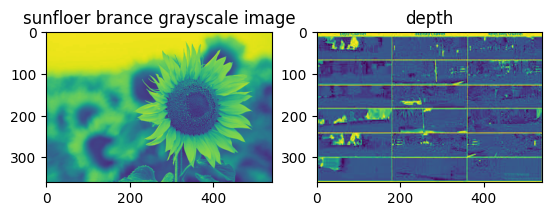

In [40]:
##We can render the transformed phpto as Numpy arrays with Matplotlib
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.title("sunfloer brance grayscale image")
plt.imshow(rgbd_image.color)

plt.subplot(1,2,2)
plt.title("depth")
plt.imshow(rgbd_image.depth)
plt.show()

In [52]:
import numpy as np

def cloud_to_image(pcd_np, resolution):
    # FIX 1: Use pcd_np instead of pcd
    minx = np.min(pcd_np[:, 0])
    maxx = np.max(pcd_np[:, 0])  # FIX 2: Changed '==' to '='
    miny = np.min(pcd_np[:, 1])
    maxy = np.max(pcd_np[:, 1])  # FIX 3: Changed [:1] to [:,1]

    width = int((maxx - minx) / resolution) + 1
    height = int((maxy - miny) / resolution) + 1  # FIX 4: Added parentheses

    image = np.zeros((height, width, 3), dtype=np.uint8)

    for point in pcd_np:
        x = point[0]  # Use indexing instead of unpacking
        y = point[1]
        z = point[2]
        r, g, b = point[-3:]  # Get RGB values

        pixel_x = int((x - minx) / resolution)
        pixel_y = int((maxy - y) / resolution)

        # FIX 5: Check bounds to avoid index errors
        if 0 <= pixel_x < width and 0 <= pixel_y < height:
            image[pixel_y, pixel_x] = [r, g, b]

    return image

# Load point cloud data
pcd = np.loadtxt('/content/drive/MyDrive/Point_cloud_data/bildstein_station1_xyz_intensity_rgb.txt')

# Check the shape and structure of your data
print(f"Point cloud shape: {pcd.shape}")
print(f"First point: {pcd[0]}")

# Orthographic projection
OrthoImage = cloud_to_image(pcd, 1.5)  # FIX 6: Fixed closing bracket
print(f"Image shape: {OrthoImage.shape}")




Point cloud shape: (29697591, 7)
First point: [   20.623    40.276    -1.999 -1031.      127.      141.      154.   ]
Image shape: (165, 151, 3)


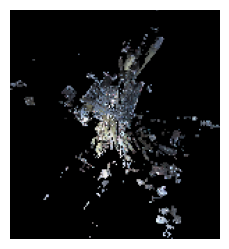

In [53]:
#Ploting and exporting
fig=plt.figure(figsize=(np.shape(OrthoImage)[1]/72,np.shape(OrthoImage)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(OrthoImage)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Point_cloud_data/point_cloud_saved_data')

Spherical projections offer a unique perspective, enabling us to visualize the data by
simulating a virtual 360° scan station. To do just this, we proceed in four steps as
illustrated in Figure 4-24:
1. Load a 3D point cloud.
2. Project each point onto a sphere.
3. Define a geometry that will retrieve the pixels.
4. “Flatten” this geometry to produce an image.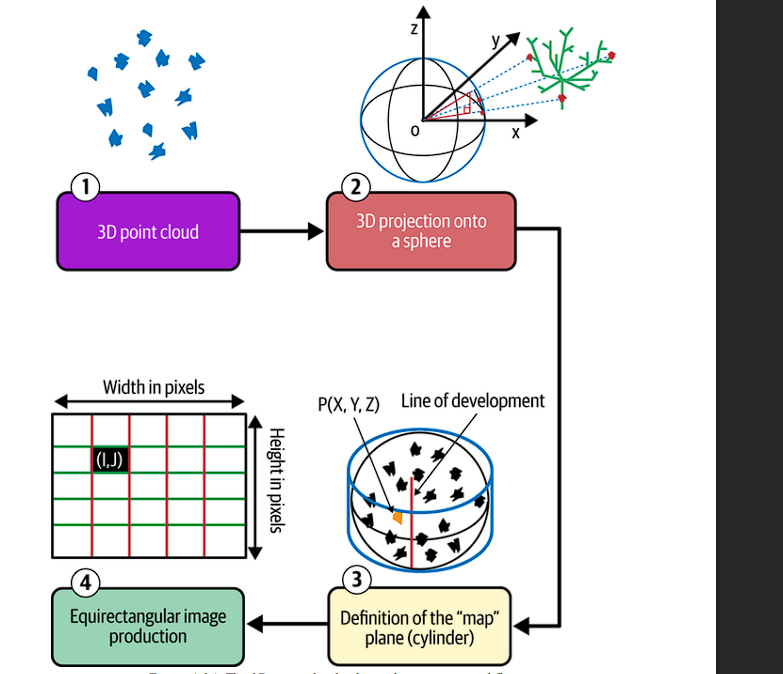

Loading file...
Loaded data shape: (29697591, 7)
Point cloud shape: (29697591, 3)
Number of points: 29697591
X range: [-104.70, 120.58]
Y range: [-133.53, 112.86]
Z range: [-17.11, 47.37]
File has 7 columns
Assuming 7-column format: x, y, z, intensity, r, g, b
Colors appear to be in 0-255 range
Colors shape: (29697591, 3)
Color range: [0, 255]
Using center coordinates: [  7.939  -10.3345  15.1315]

Generating spherical projection...
Image resolution: 500x1000
Filled pixels: 145590/500000 (29.12%)


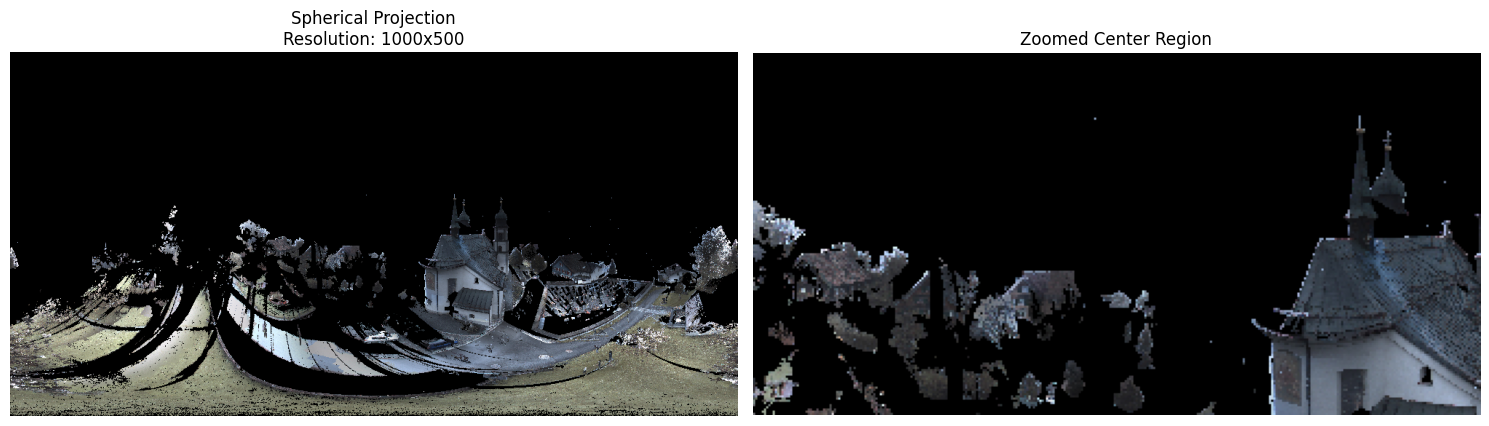


--- Statistics ---
Image size: 1000x500
Filled pixels: 145588/500000 (29.12%)
Average brightness: 34.10
Max brightness: 255.00


In [1]:
import numpy as np
import matplotlib.pyplot as plt

##3D point cloud spherical projection - FIXED VERSION
def generate_spherical_image(center_coordinates, point_clouds, colors, resolution_y=500):
    # Translate the points cloud by negation of the center coordinates
    translated_points = point_clouds - center_coordinates

    # Calculate distances from center
    distances = np.linalg.norm(translated_points, axis=1)

    # Remove points that are too close to center (division by zero issues)
    valid_mask = distances > 0.01
    translated_points = translated_points[valid_mask]
    colors = colors[valid_mask]
    distances = distances[valid_mask]

    if len(translated_points) == 0:
        print("Warning: No valid points after filtering")
        resolution_x = 2 * resolution_y
        return np.zeros((resolution_y, resolution_x, 3), dtype=np.uint8), None

    ## Convert 3D point cloud to spherical coordinates
    # theta: azimuth angle [-π, π]
    theta = np.arctan2(translated_points[:, 1], translated_points[:, 0])

    # phi: elevation angle [0, π]
    # Fix: Use safe division and clipping to avoid numerical errors
    z_normalized = translated_points[:, 2] / distances
    z_normalized = np.clip(z_normalized, -1.0, 1.0)
    phi = np.arccos(z_normalized)

    ## Map spherical coordinates to pixels coordinates
    # x: azimuth -> [0, 2*resolution_y]
    # y: elevation -> [0, resolution_y]
    x = ((theta + np.pi) / (2 * np.pi)) * (2 * resolution_y)
    y = (phi / np.pi) * resolution_y

    # Convert to integer pixel coordinates
    ix = np.clip(np.round(x).astype(int), 0, 2 * resolution_y - 1)
    iy = np.clip(np.round(y).astype(int), 0, resolution_y - 1)

    ## Create a spherical image with rgb channels
    resolution_x = 2 * resolution_y
    image = np.zeros((resolution_y, resolution_x, 3), dtype=np.uint8)

    ## Create the mapping between the point cloud and image coordinates
    mapping = np.full((resolution_y, resolution_x), -1, dtype=int)

    ## Assign point to the image pixels - VECTORIZED FOR SPEED
    # Create empty arrays for accumulation
    min_distances = np.full((resolution_y, resolution_x), np.inf)

    # Process points in batches for better performance
    batch_size = 10000
    for i in range(0, len(translated_points), batch_size):
        end_idx = min(i + batch_size, len(translated_points))
        batch_indices = np.arange(i, end_idx)

        # Get batch coordinates
        batch_ix = ix[i:end_idx]
        batch_iy = iy[i:end_idx]
        batch_dist = distances[i:end_idx]

        # Find which points are closer than current minimum at their pixel
        for j in range(len(batch_ix)):
            ix_val, iy_val, dist_val = batch_ix[j], batch_iy[j], batch_dist[j]

            if dist_val < min_distances[iy_val, ix_val]:
                min_distances[iy_val, ix_val] = dist_val
                mapping[iy_val, ix_val] = batch_indices[j]
                image[iy_val, ix_val] = colors[batch_indices[j]]

    # Count filled pixels
    filled_pixels = np.sum(mapping >= 0)
    total_pixels = resolution_y * resolution_x
    fill_percentage = (filled_pixels / total_pixels) * 100

    print(f"Image resolution: {resolution_y}x{resolution_x}")
    print(f"Filled pixels: {filled_pixels}/{total_pixels} ({fill_percentage:.2f}%)")

    return image, mapping

try:
    ## Loading the file
    print("Loading file...")
    pcd = np.loadtxt('/content/drive/MyDrive/Point_cloud_data/bildstein_station1_xyz_intensity_rgb.txt')
    print(f"Loaded data shape: {pcd.shape}")

    ## Extract coordinates (first 3 columns)
    point_cloud = pcd[:, :3]

    print(f"Point cloud shape: {point_cloud.shape}")
    print(f"Number of points: {len(point_cloud)}")

    # Check point distribution
    print(f"X range: [{point_cloud[:,0].min():.2f}, {point_cloud[:,0].max():.2f}]")
    print(f"Y range: [{point_cloud[:,1].min():.2f}, {point_cloud[:,1].max():.2f}]")
    print(f"Z range: [{point_cloud[:,2].min():.2f}, {point_cloud[:,2].max():.2f}]")

    ## Extract colors - FIXED
    # Check different column configurations
    num_columns = pcd.shape[1]
    print(f"File has {num_columns} columns")

    if num_columns >= 7:
        # Format: x, y, z, intensity, r, g, b
        print("Assuming 7-column format: x, y, z, intensity, r, g, b")
        # Check if colors are in 0-255 or 0-65535 range
        sample_r = pcd[0, 4]
        if sample_r > 255:
            print("Colors appear to be in 0-65535 range, scaling to 0-255")
            colors = (pcd[:, 4:7] / 65535 * 255).astype(np.uint8)
        else:
            print("Colors appear to be in 0-255 range")
            colors = pcd[:, 4:7].astype(np.uint8)
    elif num_columns >= 6:
        # Format: x, y, z, r, g, b
        print("Assuming 6-column format: x, y, z, r, g, b")
        sample_r = pcd[0, 3]
        if sample_r > 255:
            colors = (pcd[:, 3:6] / 65535 * 255).astype(np.uint8)
        else:
            colors = pcd[:, 3:6].astype(np.uint8)
    else:
        # No color data - create random colors
        print("No color data found, creating random colors")
        colors = np.random.randint(0, 256, (len(point_cloud), 3), dtype=np.uint8)

    print(f"Colors shape: {colors.shape}")
    print(f"Color range: [{colors.min()}, {colors.max()}]")

    ## Define center coordinates
    # Use the center of the point cloud for better results
    center_x = (point_cloud[:,0].min() + point_cloud[:,0].max()) / 2
    center_y = (point_cloud[:,1].min() + point_cloud[:,1].max()) / 2
    center_z = (point_cloud[:,2].min() + point_cloud[:,2].max()) / 2

    center_coordinates = np.array([center_x, center_y, center_z])
    print(f"Using center coordinates: {center_coordinates}")

    ## Resolution
    resolution = 500

    ## Call the function
    print("\nGenerating spherical projection...")
    spherical_image, mapping = generate_spherical_image(center_coordinates, point_cloud, colors, resolution)

    ## Display the spherical image
    plt.figure(figsize=(15, 7))

    # Show the full image
    plt.subplot(1, 2, 1)
    plt.imshow(spherical_image)
    plt.title(f"Spherical Projection\nResolution: {spherical_image.shape[1]}x{spherical_image.shape[0]}")
    plt.axis('off')

    # Show a zoomed-in portion to see details
    plt.subplot(1, 2, 2)
    # Take a central crop of the image
    h, w = spherical_image.shape[:2]
    crop_h, crop_w = h//3, w//3
    start_h, start_w = h//3, w//3
    cropped = spherical_image[start_h:start_h+crop_h, start_w:start_w+crop_w]

    if np.any(cropped > 0):  # Check if cropped area has data
        plt.imshow(cropped)
        plt.title("Zoomed Center Region")
    else:
        # If center is empty, show brightest region
        brightness = spherical_image.mean(axis=2)
        if brightness.max() > 0:
            max_pos = np.unravel_index(brightness.argmax(), brightness.shape)
            y_start = max(0, max_pos[0] - crop_h//2)
            x_start = max(0, max_pos[1] - crop_w//2)
            y_end = min(h, y_start + crop_h)
            x_end = min(w, x_start + crop_w)
            plt.imshow(spherical_image[y_start:y_end, x_start:x_end])
            plt.title("Brightest Region")
        else:
            plt.imshow(spherical_image)
            plt.title("Full Image (no bright regions found)")

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Calculate and display statistics
    brightness = spherical_image.mean(axis=2)
    filled_pixels = np.sum(brightness > 0)
    total_pixels = spherical_image.shape[0] * spherical_image.shape[1]

    print(f"\n--- Statistics ---")
    print(f"Image size: {spherical_image.shape[1]}x{spherical_image.shape[0]}")
    print(f"Filled pixels: {filled_pixels}/{total_pixels} ({filled_pixels/total_pixels*100:.2f}%)")
    print(f"Average brightness: {brightness.mean():.2f}")
    print(f"Max brightness: {brightness.max():.2f}")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

In [4]:
##K-D tree
##Calculate the k-d tree from the point cloud
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [7]:
import open3d as o3d
import numpy as np
from scipy.spatial import cKDTree

# Method 1: If you have an Open3D point cloud object
point_cloud = o3d.geometry.PointCloud()  # Your Open3D point cloud

# Calculate k-d tree using Open3D
pcd_tree = o3d.geometry.KDTreeFlann(point_cloud)
print("Open3D KDTree created")

# Method 2: If you want to use scipy's cKDTree
# First get points from Open3D point cloud
points = np.asarray(point_cloud.points)  # Note: .points, not .points()
kdtree = cKDTree(points)
print(f"SciPy KDTree created with {len(points)} points")

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Open3D KDTree created
SciPy KDTree created with 0 points


In [11]:
###Octrees
import open3d as o3d

curr_max_depth = 8
point_cloud = o3d.io.read_point_cloud('/content/drive/MyDrive/Point_cloud_data/custom_point_cloud.ply')

# Check if point cloud was loaded successfully
if point_cloud.is_empty():
    print("Error: Point cloud is empty or file not found!")
else:
    print(f"Point cloud loaded successfully!")
    print(f"Number of points: {len(point_cloud.points)}")

    # Create octree
    octree = o3d.geometry.Octree(max_depth=curr_max_depth)
    octree.convert_from_point_cloud(point_cloud, size_expand=0.01)

    # Visualize octree
    o3d.visualization.draw_geometries([octree],
                                      window_name="Octree Visualization",
                                      width=800,
                                      height=600)


Point cloud loaded successfully!
Number of points: 1000
[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


Points: 1000
Octree created successfully!
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


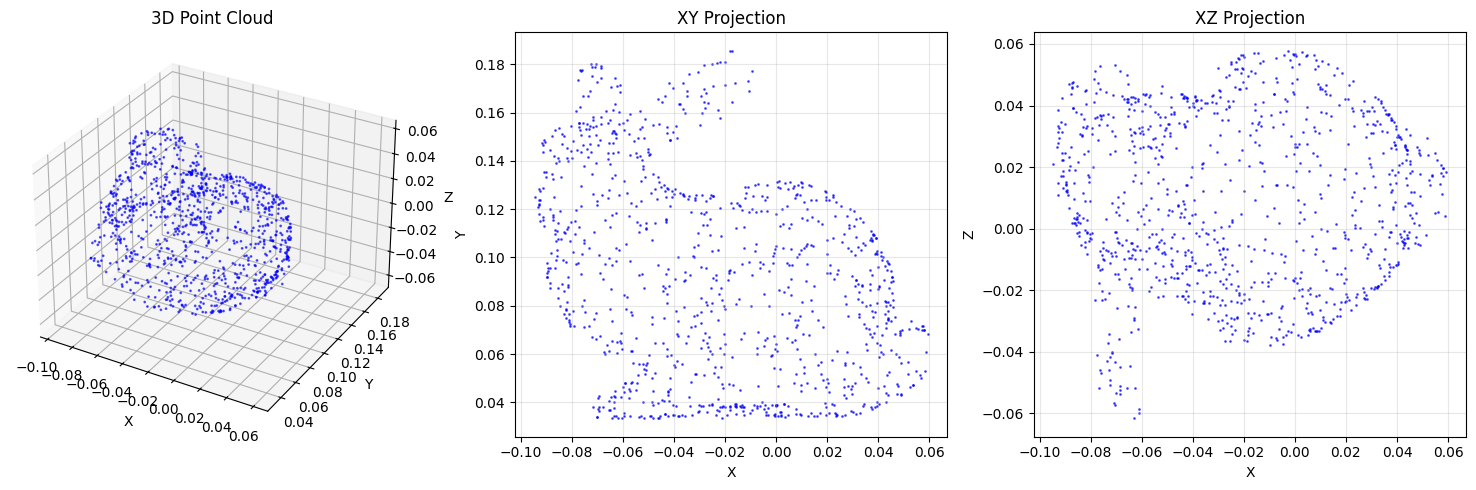

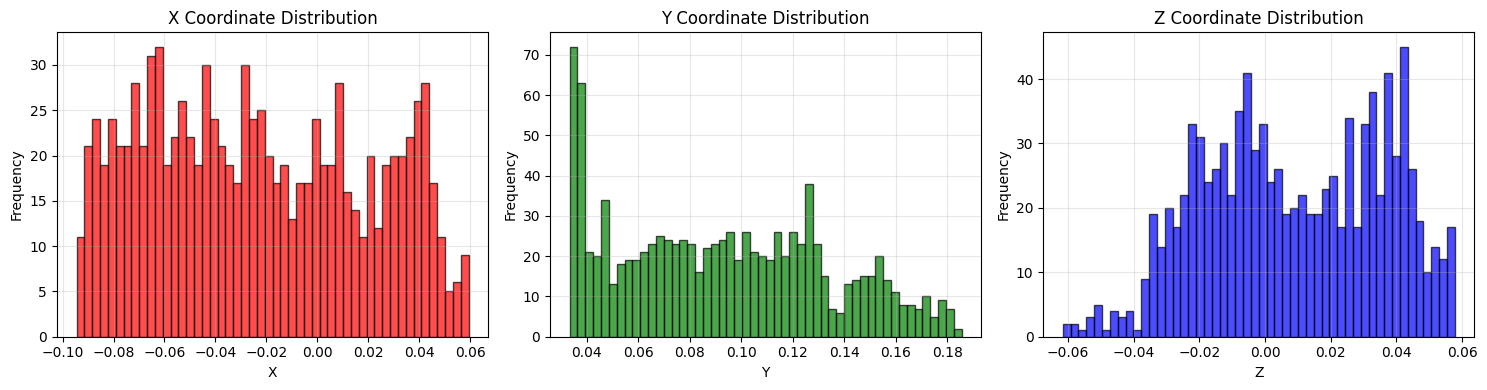

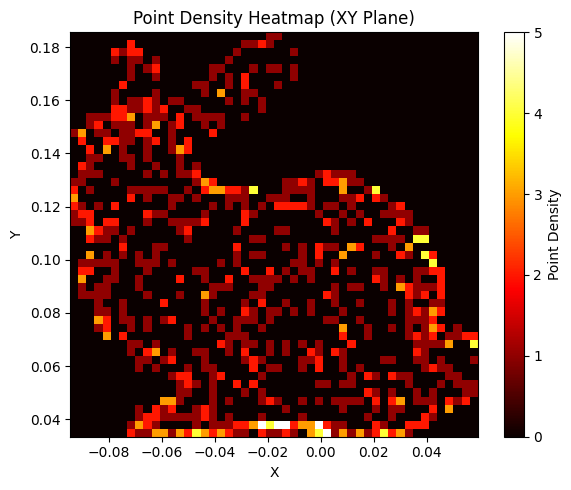


=== Point Cloud Statistics ===
Total points: 1000
X range: [-0.095, 0.059]
Y range: [0.033, 0.186]
Z range: [-0.062, 0.058]
Mean position: [-0.023, 0.093, 0.009]
Standard deviation: [0.042, 0.041, 0.027]


In [13]:
##3d representation
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

curr_max_depth = 8

# Load point cloud
point_cloud = o3d.io.read_point_cloud('/content/drive/MyDrive/Point_cloud_data/custom_point_cloud.ply')

if point_cloud.is_empty():
    print("Point cloud is empty! Creating sample...")
    # Create sample points
    points = np.random.rand(1000, 3)
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)

print(f"Points: {len(point_cloud.points)}")

# Create octree
octree = o3d.geometry.Octree(max_depth=curr_max_depth)
octree.convert_from_point_cloud(point_cloud, size_expand=0.01)

print("Octree created successfully!")

# Method 1: Open3D Visualization
try:
    # Try to visualize using Open3D's built-in visualization
    o3d.visualization.draw_geometries([octree],
                                      window_name=f"Octree Visualization (Depth: {curr_max_depth})",
                                      width=800,
                                      height=600,
                                      zoom=0.8)
except Exception as e:
    print(f"Open3D visualization failed: {e}")

    # Alternative 1: Visualize point cloud with bounding box
    bbox = point_cloud.get_axis_aligned_bounding_box()
    bbox.color = (1, 0, 0)  # Red color

    o3d.visualization.draw_geometries([point_cloud, bbox],
                                      window_name="Point Cloud with Bounding Box",
                                      width=800,
                                      height=600)

# Method 2: Matplotlib Visualization
# Extract point cloud data for matplotlib
points_array = np.asarray(point_cloud.points)
colors_array = np.asarray(point_cloud.colors) if point_cloud.has_colors() else None

# Create matplotlib figure
fig = plt.figure(figsize=(15, 5))

# Subplot 1: 3D scatter plot
ax1 = fig.add_subplot(131, projection='3d')
if colors_array is not None and len(colors_array) == len(points_array):
    ax1.scatter(points_array[:, 0], points_array[:, 1], points_array[:, 2],
                c=colors_array, s=1, alpha=0.6)
else:
    ax1.scatter(points_array[:, 0], points_array[:, 1], points_array[:, 2],
                c='blue', s=1, alpha=0.6)
ax1.set_title('3D Point Cloud')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Subplot 2: XY projection
ax2 = fig.add_subplot(132)
if colors_array is not None and len(colors_array) == len(points_array):
    ax2.scatter(points_array[:, 0], points_array[:, 1],
                c=colors_array, s=1, alpha=0.6)
else:
    ax2.scatter(points_array[:, 0], points_array[:, 1],
                c='blue', s=1, alpha=0.6)
ax2.set_title('XY Projection')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid(True, alpha=0.3)

# Subplot 3: XZ projection
ax3 = fig.add_subplot(133)
if colors_array is not None and len(colors_array) == len(points_array):
    ax3.scatter(points_array[:, 0], points_array[:, 2],
                c=colors_array, s=1, alpha=0.6)
else:
    ax3.scatter(points_array[:, 0], points_array[:, 2],
                c='blue', s=1, alpha=0.6)
ax3.set_title('XZ Projection')
ax3.set_xlabel('X')
ax3.set_ylabel('Z')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Method 3: Statistics Visualization
fig2, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of X coordinates
axes[0].hist(points_array[:, 0], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0].set_title('X Coordinate Distribution')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Histogram of Y coordinates
axes[1].hist(points_array[:, 1], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Y Coordinate Distribution')
axes[1].set_xlabel('Y')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Histogram of Z coordinates
axes[2].hist(points_array[:, 2], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[2].set_title('Z Coordinate Distribution')
axes[2].set_xlabel('Z')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Method 4: Density heatmap in XY plane
fig3 = plt.figure(figsize=(6, 5))
ax4 = fig3.add_subplot(111)

# Create 2D histogram (density plot)
heatmap, xedges, yedges = np.histogram2d(points_array[:, 0], points_array[:, 1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

im = ax4.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', aspect='auto')
ax4.set_title('Point Density Heatmap (XY Plane)')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
plt.colorbar(im, ax=ax4, label='Point Density')
plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Point Cloud Statistics ===")
print(f"Total points: {len(points_array)}")
print(f"X range: [{points_array[:, 0].min():.3f}, {points_array[:, 0].max():.3f}]")
print(f"Y range: [{points_array[:, 1].min():.3f}, {points_array[:, 1].max():.3f}]")
print(f"Z range: [{points_array[:, 2].min():.3f}, {points_array[:, 2].max():.3f}]")
print(f"Mean position: [{points_array[:, 0].mean():.3f}, {points_array[:, 1].mean():.3f}, {points_array[:, 2].mean():.3f}]")
print(f"Standard deviation: [{points_array[:, 0].std():.3f}, {points_array[:, 1].std():.3f}, {points_array[:, 2].std():.3f}]")